In [1]:
%load_ext autoreload
%autoreload 2

In [107]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

from datatools import extract_market_data, data_quantization
from pipeline import Dataset
from pipeline.backtest import evaluation_for_submission, cross_validation
from visualization.metric import plot_performance
from pandas.plotting import autocorrelation_plot

import xarray as xr
from xarray import Dataset, DataArray

sns.set_style('whitegrid')

In [4]:
base_ds = xr.open_dataset('../../data/nc/base.nc')
market_brief_ds = xr.open_dataset('../../data/nc/market_brief.nc')
ds = base_ds.merge(market_brief_ds).dropna(dim='day')

In [8]:
ds

<xarray.Dataset>
Dimensions:               (day: 998, asset: 54, timeslot: 50)
Coordinates:
  * day                   (day) int32 1 2 3 4 5 6 7 ... 993 994 995 996 997 998
  * asset                 (asset) int32 0 1 2 3 4 5 6 7 ... 47 48 49 50 51 52 53
  * timeslot              (timeslot) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
Data variables: (12/30)
    open                  (day, asset, timeslot) float64 25.02 24.96 ... 9.941
    close                 (day, asset, timeslot) float64 24.96 24.85 ... 9.941
    high                  (day, asset, timeslot) float64 25.14 24.96 ... 9.941
    low                   (day, asset, timeslot) float64 24.94 24.81 ... 9.941
    volume                (day, asset, timeslot) float64 6.422e+05 ... 1.851e+05
    money                 (day, asset, timeslot) float64 1.61e+07 ... 1.839e+06
    ...                    ...
    book                  (day, asset) float64 4.934 3.191 1.878 ... 4.989 4.981
    sales                 (day, asset) float64 6.387 5.292 2.182 ... 7.77 24.41
    cashflow              (day, asset) float64 -0.04213 0.6771 ... 0.07389
    market_share_history  (day, asset) float64 6.171e+06 3.516e+06 ... 9.775e+06
    market_share          (asset) float64 1.026e+07 7.648e+06 ... 9.775e+06
    market_cap            (asset, day) float64 2.503e+08 2.422e+08 ... 9.717e+07

## Prepare fundamental data (not clean yet)

In [6]:
ds['earnings_ttm'] = ds['close_0'] / ds['pe_ttm']
ds['earnings'] = ds['close_0'] / ds['pe']
ds['book'] = ds['close_0'] / ds['pb']
ds['sales'] = ds['close_0'] / ds['ps']
ds['cashflow'] = ds['close_0'] / ds['pcf']

In [33]:
ds['market_share_history'] = ds['volume'].sum('timeslot') / ds['turnoverRatio']
ds['market_share'] = ds['market_share_history'].sel(day=slice(990, 1000)).median(dim='day')
ds['market_cap'] = ds['market_share'] * ds['close_0']
ds['market_cap_B'] = ds['market_cap'] / 1e8

In [34]:
sds = ds.sel(day=range(300, 400)).copy()

In [22]:
bucket_close = sds.stack({'bucket': ['day', 'timeslot']})['close']
bucket_return = (bucket_close.diff('bucket') / bucket_close).unstack('bucket').fillna(0)

In [123]:
bucket_close

<xarray.DataArray 'close' (asset: 54, bucket: 5000)>
array([[16.3984, 16.5562, 16.714 , ..., 18.4255, 18.4255, 18.474 ],
       [19.6029, 19.5786, 19.6393, ..., 26.3152, 26.3637, 26.2181],
       [17.4302, 17.4544, 17.4544, ..., 21.7027, 21.6663, 21.6785],
       ...,
       [ 5.45  ,  5.4621,  5.4621, ...,  5.5471,  5.5592,  5.5592],
       [16.2649, 16.3135, 16.3377, ..., 20.6589, 20.671 , 20.671 ],
       [ 7.6712,  7.6469,  7.6712, ..., 12.3079, 12.2594, 12.2715]])
Coordinates:
  * asset     (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53
  * bucket    (bucket) object MultiIndex
  * day       (bucket) int32 300 300 300 300 300 300 ... 399 399 399 399 399 399
  * timeslot  (bucket) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50

In [35]:
sds['bucket_return'] = bucket_return

In [66]:
from tqdm.auto import tqdm

factor = ['earnings_ttm', 'book', 'sales', 'cashflow', 'market_cap_B']
target = 'bucket_return'
coefs = {}
residual_returns = {}
market_returns = {}
reg = LinearRegression()

for bucket, _ds in tqdm(sds[factor + [target]].stack({'bucket': ['day', 'timeslot']}).groupby('bucket')):
    factor_np = _ds[factor].to_array().as_numpy().T
    return_np = _ds[target].as_numpy()
    reg.fit(factor_np, return_np)
    residual_returns[bucket] = return_np - reg.predict(factor_np)
    market_returns[bucket] = reg.intercept_
    coefs[bucket] = reg.coef_

  0%|          | 0/5000 [00:00<?, ?it/s]

In [122]:
residual_returns

{(300,
  1): <xarray.DataArray 'bucket_return' (asset: 54)>
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
 Coordinates:
   * asset     (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53
     bucket    object (300, 1)
     day       int32 300
     timeslot  int32 1,
 (300,
  2): <xarray.DataArray 'bucket_return' (asset: 54)>
 array([ 0.0078571 , -0.00264604, -0.00111322, -0.00502685, -0.00295436,
         0.01022685, -0.00283999, -0.0011044 ,  0.00046831, -0.00284169,
        -0.00044086, -0.00200728, -0.00025796, -0.00521022,  0.00605558,
        -0.02193525, -0.00079831,  0.00286407,  0.00914814,  0.00346044,
         0.00407279,  0.00742991,  0.00179948,  0.00129047,  0.00141812,
         0.0016527 , -0.0031656 , -0.00437679,  0.00061431,  0.00256522,
         0.00151455

In [59]:
factor_np = _ds[factor].to_array().as_numpy().T
return_np = _ds[target].as_numpy()

In [130]:
factor_loading = xr.Dataset.from_dataframe(pd.DataFrame(data=coefs, index=factor, columns=sds['close'].sel(asset=0).to_dataframe().index).T)
market_return = xr.DataArray.from_series(pd.Series(data=market_returns, index=sds['close'].sel(asset=0).to_dataframe().index))

In [131]:
residual_return = xr.concat((xr.concat((residual_returns[(d, k)] for k in range(1, 51)), dim='timeslot') for d in range(300, 400)), dim='day').reset_coords(drop=True)

In [132]:
residual_return

<xarray.DataArray 'bucket_return' (day: 100, timeslot: 50, asset: 54)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.85709785e-03, -2.64604456e-03, -1.11321922e-03, ...,
          3.70474629e-04,  5.88866635e-04, -3.85370300e-03],
        [ 8.54748784e-03,  2.38581381e-03, -5.34280725e-04, ...,
         -6.10959328e-04,  9.37664006e-04,  2.54615142e-03],
        ...,
        [ 6.60466592e-05,  4.00846367e-03,  4.98330908e-04, ...,
         -2.34754300e-03, -1.57803334e-03, -1.85987691e-03],
        [-6.76259673e-04, -4.31138301e-04,  3.93548305e-03, ...,
         -1.08356727e-03,  2.91927353e-04,  2.20122742e-03],
        [-3.25681088e-04,  9.33939308e-04, -1.82243209e-03, ...,
          1.84206931e-03,  1.15173116e-03, -7.25618609e-04]],

       [[-2.93774640e-03,  1.19126672e-02,  1.33553222e-03, ...,
         -2.27374715e-03,  1.73653741e-03, -5.33543397e-03],
        [-5.49269552e-03, -1.08834558e-02,  1.63646300e-02, ...,
          2.24086213e-03,  5.27753994e-03,  3.07968300e-03],
        [ 4.34543615e-03, -3.13937669e-03,  9.22438183e-03, ...,
         -4.70035531e-03,  1.76851908e-02, -2.47548322e-04],
...
        [-6.90442971e-04,  5.99762333e-04, -1.69446934e-03, ...,
         -1.01251716e-03, -9.08147627e-04, -4.56796450e-04],
        [-1.02984103e-03, -1.99858619e-03, -1.15829918e-03, ...,
         -1.52065119e-03,  2.74022385e-03,  6.06314815e-03],
        [-1.66920103e-04, -1.61309844e-03, -1.50226370e-04, ...,
          2.37129140e-04, -3.97065919e-04, -1.04364171e-03]],

       [[ 3.69165963e-03, -1.29163854e-04, -3.86770273e-04, ...,
         -1.31297833e-03,  2.66083415e-02, -1.16962754e-02],
        [ 2.59116798e-03, -1.91610120e-03,  1.23508680e-03, ...,
          5.73601909e-04,  2.32135507e-02, -2.00278697e-05],
        [ 4.28488479e-03, -1.00826861e-02, -3.23907192e-03, ...,
          8.40240990e-03, -8.92699982e-03, -1.98202856e-03],
        ...,
        [-8.43072471e-04,  6.61194054e-04,  4.48394849e-04, ...,
          1.41336042e-04,  6.44151150e-04, -7.60348862e-03],
        [-2.82494261e-05,  1.60359484e-03, -2.28062415e-03, ...,
          1.84927394e-03,  2.43853104e-04, -4.21696720e-03],
        [ 2.27024735e-03, -5.69815470e-03,  4.44432109e-04, ...,
         -2.27825794e-04, -2.30710484e-04,  1.04470178e-03]]])
Coordinates:
  * asset     (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53
  * day       (day) int32 300 301 302 303 304 305 ... 394 395 396 397 398 399
  * timeslot  (timeslot) int32 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50

In [133]:
residual_return.assign_coords(bucket_num=residual_return['day'] * 50 + residual_return['timeslot'])

<xarray.DataArray 'bucket_return' (day: 100, timeslot: 50, asset: 54)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.85709785e-03, -2.64604456e-03, -1.11321922e-03, ...,
          3.70474629e-04,  5.88866635e-04, -3.85370300e-03],
        [ 8.54748784e-03,  2.38581381e-03, -5.34280725e-04, ...,
         -6.10959328e-04,  9.37664006e-04,  2.54615142e-03],
        ...,
        [ 6.60466592e-05,  4.00846367e-03,  4.98330908e-04, ...,
         -2.34754300e-03, -1.57803334e-03, -1.85987691e-03],
        [-6.76259673e-04, -4.31138301e-04,  3.93548305e-03, ...,
         -1.08356727e-03,  2.91927353e-04,  2.20122742e-03],
        [-3.25681088e-04,  9.33939308e-04, -1.82243209e-03, ...,
          1.84206931e-03,  1.15173116e-03, -7.25618609e-04]],

       [[-2.93774640e-03,  1.19126672e-02,  1.33553222e-03, ...,
         -2.27374715e-03,  1.73653741e-03, -5.33543397e-03],
        [-5.49269552e-03, -1.08834558e-02,  1.63646300e-02, ...,
          2.24086213e-03,  5.27753994e-03,  3.07968300e-03],
        [ 4.34543615e-03, -3.13937669e-03,  9.22438183e-03, ...,
         -4.70035531e-03,  1.76851908e-02, -2.47548322e-04],
...
        [-6.90442971e-04,  5.99762333e-04, -1.69446934e-03, ...,
         -1.01251716e-03, -9.08147627e-04, -4.56796450e-04],
        [-1.02984103e-03, -1.99858619e-03, -1.15829918e-03, ...,
         -1.52065119e-03,  2.74022385e-03,  6.06314815e-03],
        [-1.66920103e-04, -1.61309844e-03, -1.50226370e-04, ...,
          2.37129140e-04, -3.97065919e-04, -1.04364171e-03]],

       [[ 3.69165963e-03, -1.29163854e-04, -3.86770273e-04, ...,
         -1.31297833e-03,  2.66083415e-02, -1.16962754e-02],
        [ 2.59116798e-03, -1.91610120e-03,  1.23508680e-03, ...,
          5.73601909e-04,  2.32135507e-02, -2.00278697e-05],
        [ 4.28488479e-03, -1.00826861e-02, -3.23907192e-03, ...,
          8.40240990e-03, -8.92699982e-03, -1.98202856e-03],
        ...,
        [-8.43072471e-04,  6.61194054e-04,  4.48394849e-04, ...,
          1.41336042e-04,  6.44151150e-04, -7.60348862e-03],
        [-2.82494261e-05,  1.60359484e-03, -2.28062415e-03, ...,
          1.84927394e-03,  2.43853104e-04, -4.21696720e-03],
        [ 2.27024735e-03, -5.69815470e-03,  4.44432109e-04, ...,
         -2.27825794e-04, -2.30710484e-04,  1.04470178e-03]]])
Coordinates:
  * asset       (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53
  * day         (day) int32 300 301 302 303 304 305 ... 394 395 396 397 398 399
  * timeslot    (timeslot) int32 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
    bucket_num  (day, timeslot) int32 15001 15002 15003 ... 19998 19999 20000

In [137]:
residual_return.sel(asset=0, day=slice(300, 305))

<xarray.DataArray 'bucket_return' (day: 6, timeslot: 50)>
array([[ 0.00000000e+00,  7.85709785e-03,  8.54748784e-03,
        -1.96768115e-03,  1.14716250e-03,  3.42384220e-05,
        -3.05589287e-04, -2.48135192e-04, -2.14786101e-03,
        -7.82038638e-04, -2.12480451e-03,  8.87597600e-04,
        -7.56698054e-04,  1.22901712e-04, -1.50567892e-03,
         1.01386527e-03, -4.54480152e-03,  1.47714910e-03,
        -3.56665194e-04,  1.16773617e-03, -2.22117217e-03,
         2.25345676e-04, -4.43043184e-04,  2.32849419e-03,
        -2.88558831e-04,  3.10999399e-03, -4.27576479e-03,
        -2.59069162e-03,  1.41644560e-03, -8.37089898e-04,
        -3.16988745e-03,  1.25368928e-03, -1.96702566e-04,
         3.40534899e-04,  5.27783425e-03,  1.48264602e-03,
        -1.08362366e-03,  9.50469903e-03,  8.04938404e-03,
         8.67230996e-03,  1.11670350e-03, -5.75681480e-03,
        -6.23808590e-03,  1.29827742e-03,  3.08834591e-03,
        -2.34281491e-03, -1.91066106e-03,  6.60466592e-05,
        -6.76259673e-04, -3.25681088e-04],
       [-2.93774640e-03, -5.49269552e-03,  4.34543615e-03,
        -2.97250886e-03, -1.77043061e-03, -2.07321135e-03,
         4.24855732e-03, -6.79640290e-04,  2.36669575e-03,
...
        -1.36976532e-03, -3.43122547e-04, -3.00812266e-03,
         1.68066259e-03,  1.93610775e-03, -2.65953226e-03,
        -1.15815882e-03,  2.36366342e-04],
       [ 2.76766410e-03,  2.43963098e-03,  5.38352403e-03,
        -4.89018308e-03, -3.68834052e-03, -5.37910406e-04,
        -9.05020274e-04,  1.23412462e-03,  1.49064485e-03,
         3.86286579e-04,  5.97768040e-04, -2.23883363e-03,
         4.66526091e-04,  1.29890891e-03, -1.10555268e-03,
         6.50530777e-04, -2.19383418e-05,  1.99217757e-04,
         1.51460881e-03, -4.35973107e-04,  4.92903799e-04,
         2.11312551e-03, -1.26565343e-03,  1.34056759e-04,
        -5.20965829e-04, -1.02239908e-03, -8.98131881e-05,
        -7.62003289e-04, -1.19306314e-03, -2.99237002e-05,
         3.25446171e-04,  2.78402912e-03, -2.14983233e-03,
         1.70585413e-03, -5.61238921e-05,  2.50659065e-03,
        -3.41146714e-03,  5.22934685e-04, -5.71601329e-04,
        -3.70543575e-05,  4.21111705e-03, -3.40841383e-03,
        -9.82855892e-04,  9.27333761e-04, -1.18810131e-04,
        -1.94212430e-03,  2.17681730e-03, -1.37354232e-03,
         7.51231225e-04,  2.63653836e-04]])
Coordinates:
    asset     int32 0
  * day       (day) int32 300 301 302 303 304 305
  * timeslot  (timeslot) int32 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50

In [138]:
res_return_a0 = residual_return.sel(asset=0).to_series()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

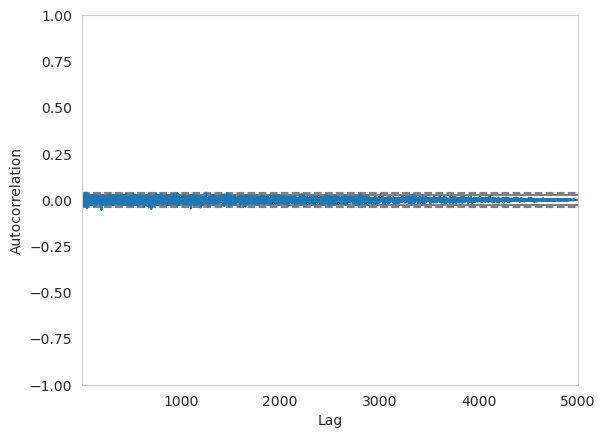

In [139]:
autocorrelation_plot(res_return_a0)

<Axes: xlabel='day,timeslot'>

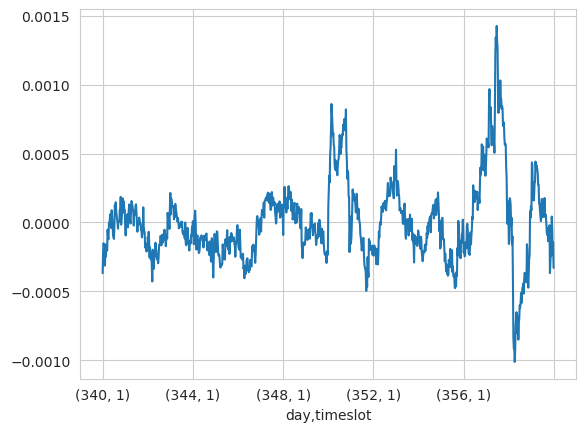

In [153]:
res_return_a0.rolling(window=40).mean()[2000:3000].plot()

In [143]:
daily_residual_return = np.exp(np.log(residual_return+1).sum('timeslot')) - 1

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

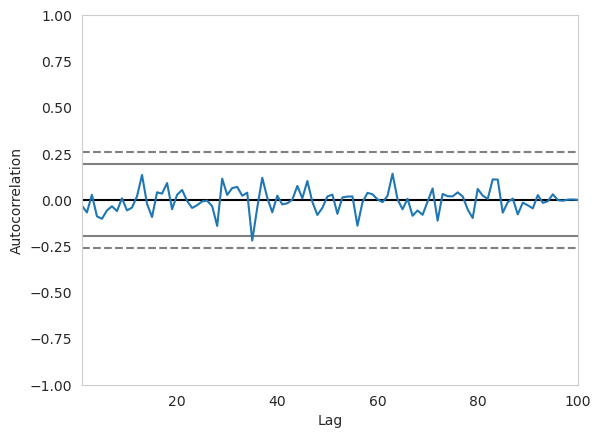

In [147]:
autocorrelation_plot(daily_residual_return.sel(asset=1).to_series())

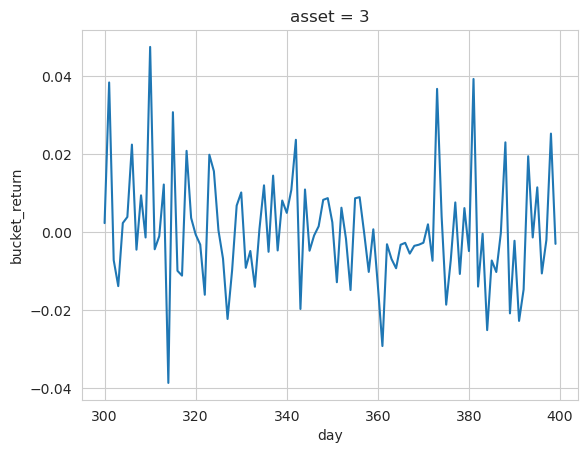

In [150]:
daily_residual_return.sel(asset=3).plot.line(x='day')

<Axes: xlabel='day,timeslot'>

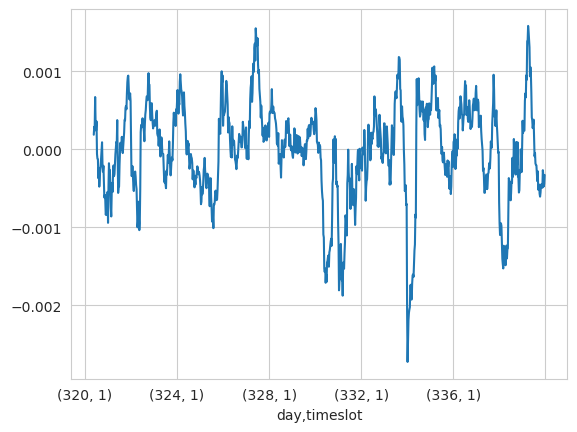

In [159]:
market_return.to_series()[1000:2000].rolling(20).mean().plot()

<Axes: xlabel='day,timeslot'>

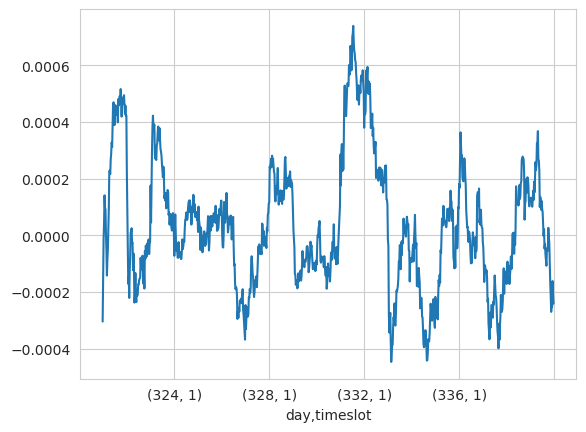

In [164]:
factor_loading['earnings_ttm'].to_series()[1000:2000].rolling(50).mean().plot()